# Sensitivity to parameter choices
In this notebook, we examine some effects of choices that can be made in our pipeline.

In [1]:
import os
import correa
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
import pyefd
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "browser" #set the renderer to browser

In [2]:
dataset = "X1" #select the dataset to analyse and the set the correct width and height of the images
if dataset == "X1":
	width=1500 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1692 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
elif dataset == "X2":
	width=1455
	height=1584
elif dataset == "X3":
	width=1919
	height=1467
elif dataset == "Y1":
	width=1226 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1088 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
else:
	raise ValueError("Dataset not supported")

files = os.listdir(dataset+"/cell/raw_images") #get all of the files in the cell/raw_images directory
cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')] #get the cell numbers from the file names
n_cells = len(cell_names)


In [ ]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 
 
def plot_dendrogram(model, **kwargs):
	# Create linkage matrix and then plot the dendrogram
	# create the counts of samples under each node
	counts = numpy.zeros(model.children_.shape[0])
	n_samples = len(model.labels_)
	for i, merge in enumerate(model.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([model.children_, model.distances_, counts]).astype(float)
	# Plot the corresponding dendrogram
	plt.figure(figsize=(2000,2000))
	plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
	dendrogram(linkage_matrix, **kwargs)

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind[i].loc[j] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, n_colours : int , cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], show2d = False, showElbow=False, colour_list=hex_list):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists[inds].loc[inds]
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists[inds].loc[inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=n_colours, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt
		# Dendrogram
		D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
		#plt.xlabel(name+" "+link)
		plt.yticks([])
		plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
		plt.show()
	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
			fig = px.scatter(df, x='x', y='y',color=link+str(k), title=name+" ("+link+" "+str(k)+")", hover_data=[df.index], width=800, height=600, color_discrete_map={
                "0": hex_list[0], "1": hex_list[1],"2": hex_list[1],"2": hex_list[2], "3": hex_list[3]})
			fig.update_traces(marker={'size': 5})
			if show2d:
				fig.show()
			fig.write_image(dir+"/"+name.replace(" ","_")+"_"+link+str(k)+"_2D.png")
	if showElbow:
		plt.plot(cluster_numbers, sse)
		plt.title("Elbow Method")
		plt.xlabel("Number of Clusters")
		plt.xticks(cluster_numbers)
		plt.ylabel("SSE")
		plt.savefig(dir+"/"+name.replace(" ","_")+"_kmeans-elbow.png")
		fig.show()
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
		#percentages_dict["kmeans++{}".format(k)] = population_percentages(df, "kmeans++"+str(k))
		#print("kmeans++{}".format(k), percentages_dict["kmeans++{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists[main_index].loc[main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))

In [4]:
centers = pandas.read_csv(dataset+"/Nuc_Cm_"+dataset+".csv", index_col="filename") #Load the center of the nucleus, labled by the nucleus file name

In [6]:
contours_cleaning = [] #list of contours
contours_no_cleaning = [] #list of contours
wd_diff = []
for i in cell_names:
	print(i)
	actin = tifffile.imread(dataset+"/cell/raw_images/"+str("%03d" % i)+".tif") #we need to know the size of the original image to shift the center of the nucleus to the correct position
	height_diff = height - actin.shape[0]
	width_diff = width - actin.shape[1]
	c_clean = correa.only_persistence_polygon(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv", [centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2], True)
	c_no_clean = correa.only_persistence_polygon(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv", [centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2], False)
	# diff, c_no_clean, c_clean = correa.test_sensitivity_polygon(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv", [centers.loc[i,"X_m"]+width_diff/2,centers.loc[i,"Y_m"]+height_diff/2])
	wd_diff.append(correa.wasserstein_distance(c_clean, c_no_clean, q=2))
	contours_cleaning.append(c_clean)
	contours_no_cleaning.append(c_no_clean)


106
112
72
66
99
98
67
73
113
107
111
105
139
65
71
59
58
70
64
138
104
110
128
114
100
48
60
74
75
61
49
101
115
129
103
117
77
63
88
89
62
76
116
102
11
5
39
38
4
10
6
12
13
7
3
17
16
2
28
14
0
1
15
29
30
24
18
19
25
31
27
33
32
26
22
36
37
23
9
35
21
20
34
8
127
133
53
47
90
84
85
91
46
52
132
126
130
124
118
44
50
78
87
93
92
86
79
51
45
119
125
131
109
135
121
69
41
55
82
96
97
83
54
40
68
120
134
108
122
136
56
42
95
81
80
94
43
57
137
123


In [7]:
print(max(wd_diff))

89.00904677798957


In [8]:
diff_pd = pandas.DataFrame(wd_diff, index=cell_names)
diff_pd.columns = ["diff"]
diff_pd.to_csv(dataset+"/wd_diff.csv")

In [9]:
high_diff_cells = diff_pd[diff_pd["diff"] > 50].index.tolist()
print(f"Cells with high cleaning difference (>50): {high_diff_cells}")


Cells with high cleaning difference (>50): [106, 110, 42]


In [10]:
px.scatter(diff_pd, y="diff", hover_data=[diff_pd.index])

In [11]:
clean_distances = numpy.zeros((n_cells,n_cells))
for i in range(n_cells):
	for j in range(i,n_cells):
		dist = correa.wasserstein_distance(contours_cleaning[i], contours_cleaning[j], q=2)
		clean_distances[i,j] = dist
		clean_distances[j,i] = dist
	print("did ", i)

did  0
did  1
did  2
did  3
did  4
did  5
did  6
did  7
did  8
did  9
did  10
did  11
did  12
did  13
did  14
did  15
did  16
did  17
did  18
did  19
did  20
did  21
did  22
did  23
did  24
did  25
did  26
did  27
did  28
did  29
did  30
did  31
did  32
did  33
did  34
did  35
did  36
did  37
did  38
did  39
did  40
did  41
did  42
did  43
did  44
did  45
did  46
did  47
did  48
did  49
did  50
did  51
did  52
did  53
did  54
did  55
did  56
did  57
did  58
did  59
did  60
did  61
did  62
did  63
did  64
did  65
did  66
did  67
did  68
did  69
did  70
did  71
did  72
did  73
did  74
did  75
did  76
did  77
did  78
did  79
did  80
did  81
did  82
did  83
did  84
did  85
did  86
did  87
did  88
did  89
did  90
did  91
did  92
did  93
did  94
did  95
did  96
did  97
did  98
did  99
did  100
did  101
did  102
did  103
did  104
did  105
did  106
did  107
did  108
did  109
did  110
did  111
did  112
did  113
did  114
did  115
did  116
did  117
did  118
did  119
did  120
did  121
did  122
did

In [12]:
no_clean_distances = numpy.zeros((n_cells,n_cells))
for i in range(n_cells):
	for j in range(i,n_cells):
		dist = correa.wasserstein_distance(contours_no_cleaning[i], contours_no_cleaning[j], q=2)
		no_clean_distances[i,j] = dist
		no_clean_distances[j,i] = dist
	print("did ", i)

did  0
did  1
did  2
did  3
did  4
did  5
did  6
did  7
did  8
did  9
did  10
did  11
did  12
did  13
did  14
did  15
did  16
did  17
did  18
did  19
did  20
did  21
did  22
did  23
did  24
did  25
did  26
did  27
did  28
did  29
did  30
did  31
did  32
did  33
did  34
did  35
did  36
did  37
did  38
did  39
did  40
did  41
did  42
did  43
did  44
did  45
did  46
did  47
did  48
did  49
did  50
did  51
did  52
did  53
did  54
did  55
did  56
did  57
did  58
did  59
did  60
did  61
did  62
did  63
did  64
did  65
did  66
did  67
did  68
did  69
did  70
did  71
did  72
did  73
did  74
did  75
did  76
did  77
did  78
did  79
did  80
did  81
did  82
did  83
did  84
did  85
did  86
did  87
did  88
did  89
did  90
did  91
did  92
did  93
did  94
did  95
did  96
did  97
did  98
did  99
did  100
did  101
did  102
did  103
did  104
did  105
did  106
did  107
did  108
did  109
did  110
did  111
did  112
did  113
did  114
did  115
did  116
did  117
did  118
did  119
did  120
did  121
did  122
did

In [13]:
clean_distances = pandas.DataFrame(clean_distances, index=cell_names, columns=cell_names)
no_clean_distances = pandas.DataFrame(no_clean_distances, index=cell_names, columns=cell_names)

In [14]:
px.scatter(wd_diff)

In [15]:
px.imshow(clean_distances.to_numpy(),width=500, height=500)

In [16]:
px.imshow(no_clean_distances.to_numpy(),width=500, height=500)

In [17]:
px.imshow(clean_distances.to_numpy()-no_clean_distances.to_numpy(),width=500, height=500)

/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



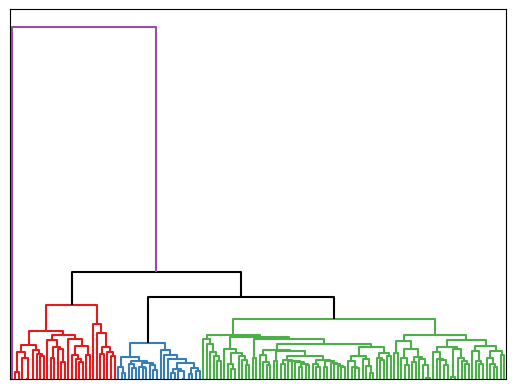

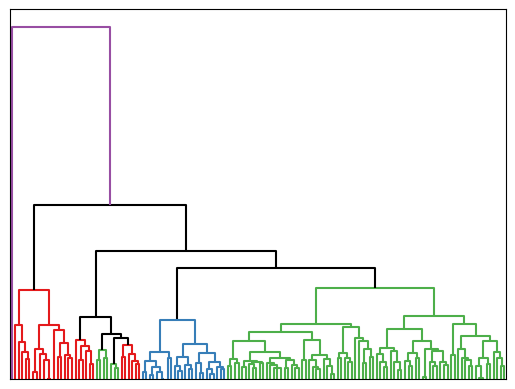

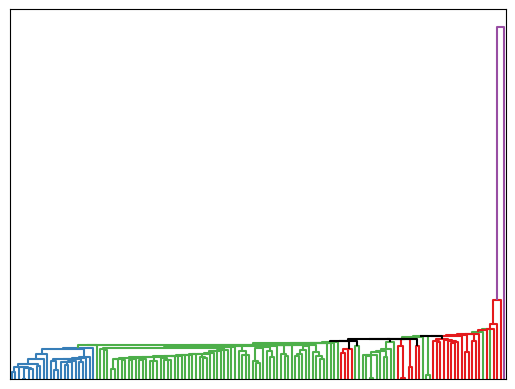

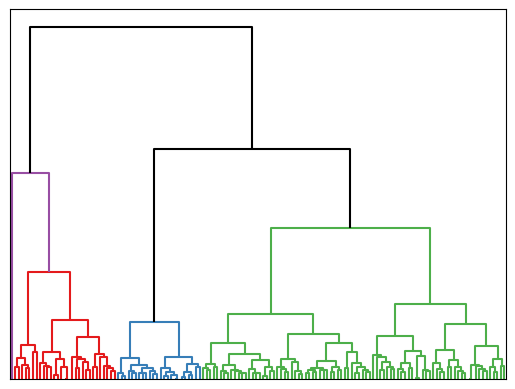

cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [122, 1, 17] [0.8714285714285714, 0.007142857142857143, 0.12142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [103, 19, 17, 1] [0.7357142857142858, 0.1357142857142857, 0.12142857142857143, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007142857142857143]
ward4 [86, 29, 24, 1] [0.6142857142857143, 0.20714285714285716, 0.17142857142857143, 0.007142857142857143]
cluster sizes and percentages are:
average5 [86, 22, 7, 1, 24] [0.6142857142857143, 0.15714285714285714, 0.05, 0.007142857142857143, 0.17142857142857143

/var/folders/_s/rctc37v96sg862kdhqxpsm340000gn/T/ipykernel_19493/1211669091.py:43: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/_s/rctc37v96sg862kdhqxpsm340000gn/T/ipykernel_19493/1211669091.py:43: FutureWarning:

ChainedAssign

In [48]:
A_clean = analysis(clean_distances, [3,4,5], dataset+"_clean", dataset)


/Users/yossi/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



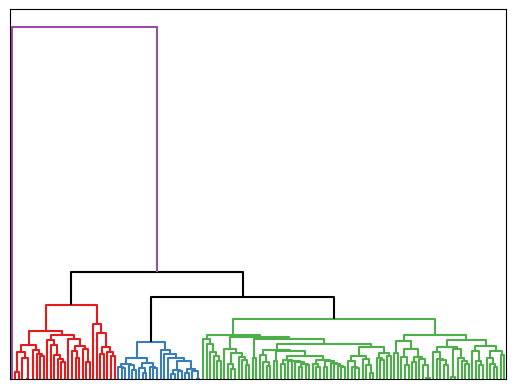

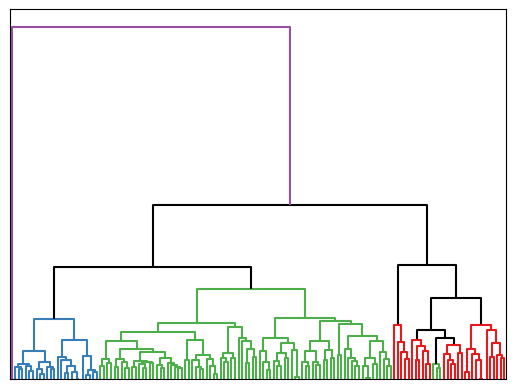

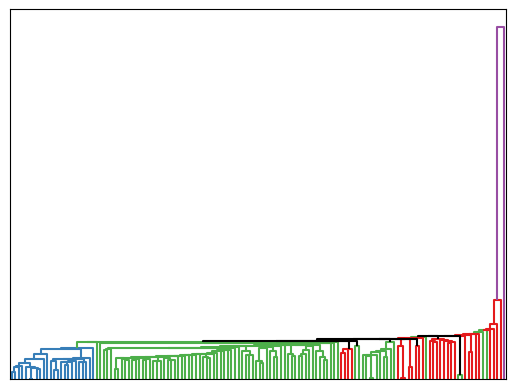

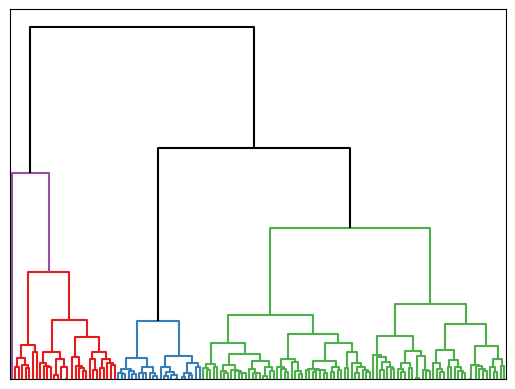

cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [32, 1, 107] [0.22857142857142856, 0.007142857142857143, 0.7642857142857142]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [107, 5, 27, 1] [0.7642857142857142, 0.03571428571428571, 0.19285714285714287, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007142857142857143]
ward4 [86, 29, 24, 1] [0.6142857142857143, 0.20714285714285716, 0.17142857142857143, 0.007142857142857143]
cluster sizes and percentages are:
average5 [86, 22, 7, 1, 24] [0.6142857142857143, 0.15714285714285714, 0.05, 0.007142857142857143, 0.17142857142857143

/var/folders/_s/rctc37v96sg862kdhqxpsm340000gn/T/ipykernel_19493/1211669091.py:43: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/_s/rctc37v96sg862kdhqxpsm340000gn/T/ipykernel_19493/1211669091.py:43: FutureWarning:

ChainedAssign

In [22]:
A_no_clean = analysis(no_clean_distances, [3,4,5], dataset+"_no_cleaning", dataset)


In [47]:
n_c = A_clean[0].shape[0]
print(n_c)
for j, link in enumerate(["average", "complete", "single", "ward"]):
	for k in range(4):
		clus = set(())
		for i in range(len(A_clean[0][link+str(4)])):
			if A_clean[0][link+str(4)].iloc[i] == str(k):
				clus.add(i)
		print(link+" cluster "+str(k)+": "+str(purity(A_no_clean[6][j], clus, n_c)[1]))
		# print("complete: "+str(purity(A_no_clean[6][1], clus, n_c)[1]))
		# print("single: "+str(purity(A_no_clean[6][2], clus, n_c)[1]))
		# print("ward: "+str(purity(A_no_clean[6][3], clus, n_c)[1]))

140
average cluster 0: 1.0
average cluster 1: 1.0
average cluster 2: 1.0
average cluster 3: 1.0
complete cluster 0: 0.8918918918918919
complete cluster 1: 0.008264462809917356
complete cluster 2: 0.8780487804878049
complete cluster 3: 1.0
single cluster 0: 1.0
single cluster 1: 1.0
single cluster 2: 1.0
single cluster 3: 1.0
ward cluster 0: 1.0
ward cluster 1: 1.0
ward cluster 2: 1.0
ward cluster 3: 1.0


In [35]:
A_no_clean[6][1]

array([[5.60000000e+01, 7.00000000e+01, 5.69957690e+00, 2.00000000e+00],
       [5.20000000e+01, 5.40000000e+01, 9.37547436e+00, 2.00000000e+00],
       [9.20000000e+01, 1.00000000e+02, 1.25622464e+01, 2.00000000e+00],
       [3.90000000e+01, 1.34000000e+02, 5.09803068e+01, 2.00000000e+00],
       [0.00000000e+00, 4.70000000e+01, 9.52612402e+01, 2.00000000e+00],
       [6.10000000e+01, 1.28000000e+02, 1.16025966e+02, 2.00000000e+00],
       [7.00000000e+00, 1.10000000e+02, 1.24899045e+02, 2.00000000e+00],
       [1.70000000e+01, 7.60000000e+01, 1.31999817e+02, 2.00000000e+00],
       [4.80000000e+01, 5.10000000e+01, 1.51752688e+02, 2.00000000e+00],
       [9.80000000e+01, 1.40000000e+02, 1.57174364e+02, 3.00000000e+00],
       [6.40000000e+01, 1.17000000e+02, 1.66396933e+02, 2.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.87413918e+02, 2.00000000e+00],
       [1.13000000e+02, 1.16000000e+02, 2.10669124e+02, 2.00000000e+00],
       [1.44000000e+02, 1.50000000e+02, 2.12166621e